### Neural ODEs TUTORIAL
https://github.com/DiffEqML/

https://github.com/rtqichen/torchdiffeq/tree/master

https://github.com/Lightning-AI/pytorch-lightning

https://lightning.ai/docs/pytorch/stable/starter/introduction.html

https://arxiv.org/abs/2008.02389

https://arxiv.org/abs/1806.07366

In [2]:
from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn import *

%load_ext autoreload
%autoreload 2

In [3]:
# quick run for automated notebook validation
dry_run = False

### Generate data from a static toy dataset
We’ll be generating data from toy datasets. In torchdyn, we provide a wide range of datasets often use to benchmark and understand Neural ODEs. Here we will use the classic moons dataset and train a Neural ODE for binary classification

In [4]:
# classification
d = ToyDataset()
X, yn = d.generate(n_samples=512, noise=1e-1, dataset_type='moons')  

In [5]:
print(len(X))
print(X)
print(yn)

512
tensor([[1.0997, 0.0997],
        [1.0098, 0.0222],
        [1.0360, 0.0609],
        ...,
        [2.0381, 0.5137],
        [2.0750, 0.5628],
        [2.0477, 0.5477]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 

<Axes: >

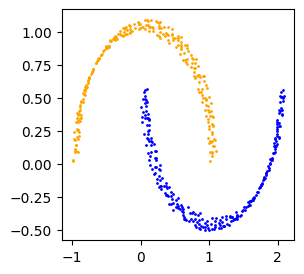

In [6]:
import matplotlib.pyplot as plt

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
# subplot: where do you want the plot to show; 111 start from top left
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], s=1, color=colors[yn[i].int()])
ax

Generated data can be easily loaded in the dataloader with standard PyTorch calls

In [7]:
import torch
import torch.utils.data as data
device = torch.device("cpu") # all of this works in GPU as well :)

X_train = torch.Tensor(X).to(device)
y_train = torch.Tensor(yn.to(device))
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=True)

We utilize Pytorch Lightning to handle training loops, logging and general bookkeeping. This allows torchdyn and Neural Differential Equations to have access to modern best practices for training and experiment reproducibility.

In particular, we combine modular torchdyn models with LightningModules via a Learner class:

In [8]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span

    # one entire forward pass of the NN
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        print(x)
        print(y)
        t_eval, y_hat = self.model(x, self.t_span)
        y_hat = y_hat[-1] # select last point of solution trajectory
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

In [10]:
t_span = torch.linspace(0,1,100)
t_eval, trajectory = model(X_train, t_span)
trajectory = trajectory.detach().cpu()

In [11]:
f = nn.Sequential(
        nn.Linear(2, 16),
        nn.Tanh(),
        nn.Linear(16, 2)                       
    )

model = NeuralODE(f, sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4).to(device)

learn = Learner(t_span, model)
if dry_run: trainer = pl.Trainer(min_epochs=1, max_epochs=1)
else: trainer = pl.Trainer(min_epochs=200, max_epochs=300)
trainer.fit(learn)

GPU available: False, used: False


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\zheyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 82    
------------------------------------
82        Trainable params
0         Non-trainable params
82        Total params
0.000     Total estimated model params size (MB)
C:\Users\zheyu\AppData\Local\Programs\Python\Python312\Lib\site

Training: |                                                                                      | 0/? [00:00<…

tensor([[ 1.5316, -0.3250],
        [ 0.8587,  0.6720],
        [ 0.2419,  1.0767],
        ...,
        [ 0.1581,  0.1486],
        [ 0.6196, -0.3627],
        [ 1.2143, -0.4670]])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 1

C:\Users\zheyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


Text(0.5, 1.0, 'Dimension 1')

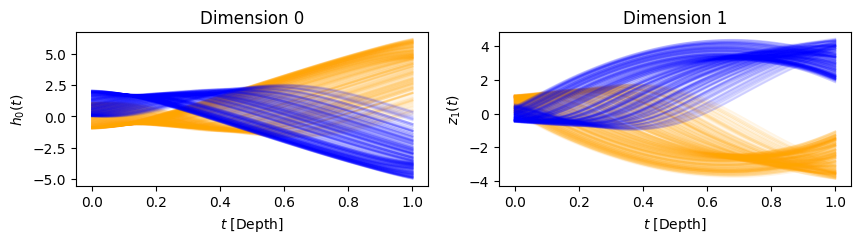

In [182]:
color=['orange', 'blue']

fig = plt.figure(figsize=(10,2))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for i in range(500):
    ax0.plot(t_span, trajectory[:,i,0], color=color[int(yn[i])], alpha=.1);
    ax1.plot(t_span, trajectory[:,i,1], color=color[int(yn[i])], alpha=.1);
ax0.set_xlabel(r"$t$ [Depth]") ; ax0.set_ylabel(r"$h_0(t)$")
ax1.set_xlabel(r"$t$ [Depth]") ; ax1.set_ylabel(r"$z_1(t)$")
ax0.set_title("Dimension 0") ; ax1.set_title("Dimension 1")

In [194]:
for i in range(len(trajectory[0])):
    print("x: " + str(trajectory[0][i]) + " y: " + str(trajectory[-1][i]))

x: tensor([1.0269, 0.0269]) y: tensor([ 0.1646, -2.9755])
x: tensor([1.0583, 0.0707]) y: tensor([ 0.2923, -3.0933])
x: tensor([1.0412, 0.0662]) y: tensor([ 0.3985, -3.1124])
x: tensor([1.0636, 0.1013]) y: tensor([ 0.4612, -3.1853])
x: tensor([1.0084, 0.0589]) y: tensor([ 0.5955, -3.1373])
x: tensor([1.0918, 0.1553]) y: tensor([ 0.4967, -3.2683])
x: tensor([1.0218, 0.0984]) y: tensor([ 0.8064, -3.2428])
x: tensor([1.0234, 0.1132]) y: tensor([ 0.8970, -3.2790])
x: tensor([1.0794, 0.1827]) y: tensor([ 0.7395, -3.3546])
x: tensor([1.0176, 0.1344]) y: tensor([ 1.0847, -3.3304])
x: tensor([1.0536, 0.1841]) y: tensor([ 1.0026, -3.3955])
x: tensor([1.0130, 0.1573]) y: tensor([ 1.2594, -3.3750])
x: tensor([1.0192, 0.1774]) y: tensor([ 1.3049, -3.4070])
x: tensor([1.0077, 0.1800]) y: tensor([ 1.4252, -3.4113])
x: tensor([1.0340, 0.2204]) y: tensor([ 1.3372, -3.4676])
x: tensor([1.0618, 0.2626]) y: tensor([ 1.1700, -3.5074])
x: tensor([1.0276, 0.2428]) y: tensor([ 1.4721, -3.4987])
x: tensor([1.0

In [145]:
x = torch.Tensor([[a] for a in torch.linspace(-20, 20, 81)])
y = torch.exp(x.flatten())

In [146]:
class Exponential_Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span

    # one entire forward pass of the NN
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch      
        t_eval, y_hat = self.model(x, self.t_span)
        y_hat = y_hat[-1] # select last point of solution trajectory
        loss = nn.MSELoss()(y_hat, y)
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

In [147]:
x_train = torch.Tensor(x).to(device)
y_train = torch.Tensor(y.to(device))
train = data.TensorDataset(x_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(x), shuffle=True)

In [168]:
f = nn.Sequential(
        nn.Linear(1, 16),
        nn.ELU(),
        nn.Linear(16, 1)                       
    )

modelE = NeuralODE(f, sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4).to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [169]:
t_span = torch.linspace(0,1,100)
learnE = Exponential_Learner(t_span, modelE)
if dry_run: trainer = pl.Trainer(min_epochs=1, max_epochs=1)
else: trainer = pl.Trainer(min_epochs=200, max_epochs=300)
trainer.fit(learnE)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 49    
------------------------------------
49        Trainable params
0         Non-trainable params
49        Total params
0.000     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:/Users/zheyu/OneDrive/Documents/GitHub/Senior-Project/lightning_logs/version_22/checkpoints/epoch=45-step=46.ckpt'

In [172]:
t_eval, trajectory = modelE(x_train, t_span)
trajectory = trajectory.detach().cpu()

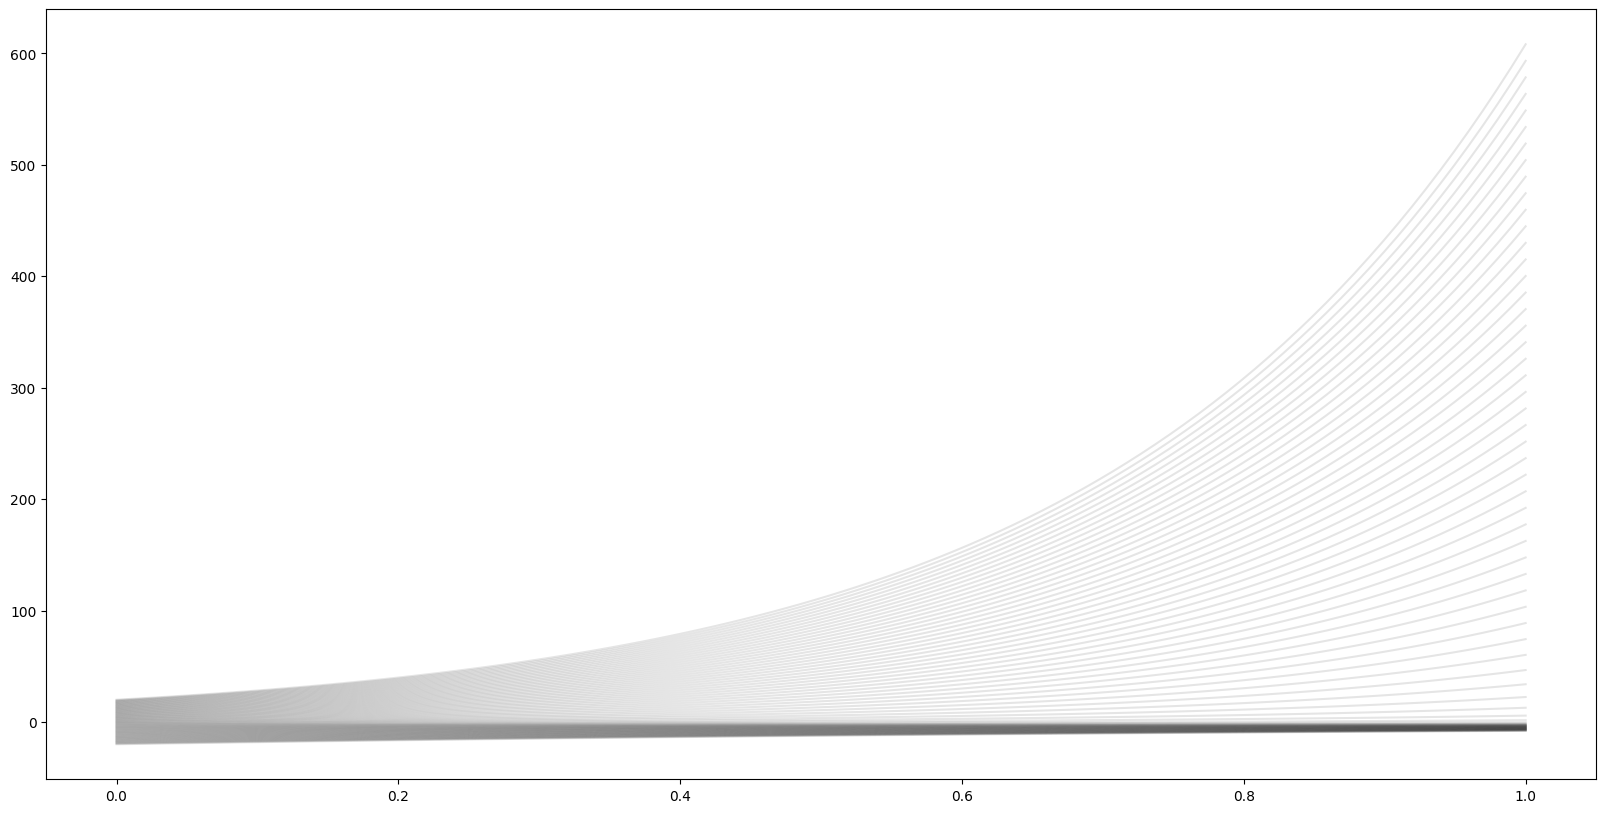

In [179]:
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(111)
for i in range(81):
    ax0.plot(t_span, trajectory[:,i], color='black', alpha=.1);

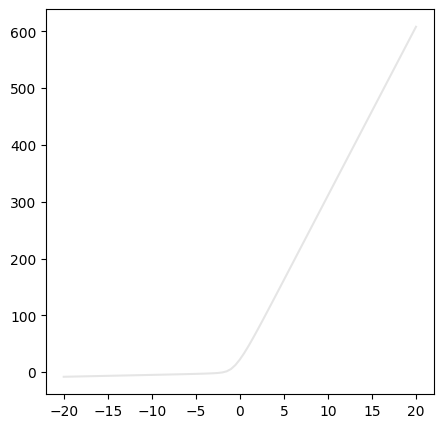

In [177]:
fig = plt.figure(figsize=(5,5))
ax0 = fig.add_subplot(111)
ax0.plot(x, trajectory[-1,:], color='black', alpha=.1);

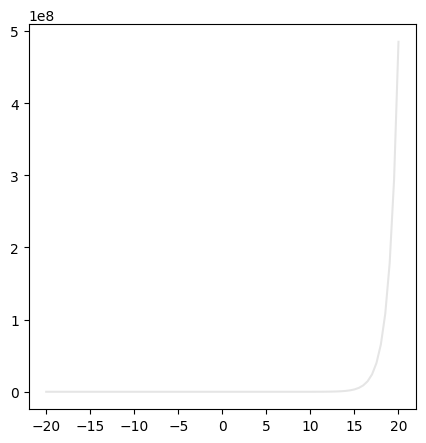

In [162]:
fig = plt.figure(figsize=(5,5))
ax0 = fig.add_subplot(111)
ax0.plot(x, y, color='black', alpha=.1);